This example shows a slightly more complex LLM example.

In [1]:
# load some extensions / magic...
%load_ext hamilton_magic
%reload_ext hamilton_magic
# load extension
%load_ext autoreload
# configure autoreload to only affect specified files
%autoreload 1

In [3]:
# import the base libraries
from hamilton import driver
import pprint
import openai

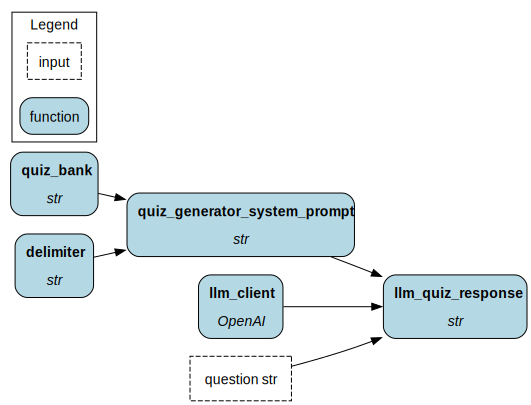

In [4]:
%%with_functions -m quiz
import openai

def quiz_bank() -> str:
    return """1. Subject: Leonardo DaVinci
   Categories: Art, Science
   Facts:
    - Painted the Mona Lisa
    - Studied zoology, anatomy, geology, optics
    - Designed a flying machine

2. Subject: Paris
   Categories: Art, Geography
   Facts:
    - Location of the Louvre, the museum where the Mona Lisa is displayed
    - Capital of France
    - Most populous city in France
    - Where Radium and Polonium were discovered by scientists Marie and Pierre Curie

3. Subject: Telescopes
   Category: Science
   Facts:
    - Device to observe different objects
    - The first refracting telescopes were invented in the Netherlands in the 17th Century
    - The James Webb space telescope is the largest telescope in space. It uses a gold-berillyum mirror

4. Subject: Starry Night
   Category: Art
   Facts:
    - Painted by Vincent van Gogh in 1889
    - Captures the east-facing view of van Gogh's room in Saint-Rémy-de-Provence

5. Subject: Physics
   Category: Science
   Facts:
    - The sun doesn't change color during sunset.
    - Water slows the speed of light
    - The Eiffel Tower in Paris is taller in the summer than the winter due to expansion of the metal.
"""

def delimiter() -> str:
    return "####"

def quiz_generator_system_prompt(delimiter: str, quiz_bank: str) -> str:
    return f"""Follow these steps to generate a customized quiz for the user.
The question will be delimited with four hashtags i.e {delimiter}

Step 1:{delimiter} First identify the category user is asking about from the following list:
* Geography
* Science
* Art

Step 2:{delimiter} Determine the subjects to generate questions about. The list of topics are below:

{quiz_bank}

Pick up to two subjects that fit the user's category.

Step 3:{delimiter} Generate a quiz for the user. Based on the selected subjects generate 3 questions for the user using the facts about the subject.
* Include any facts that might be interesting

Use the following format:
Question 1:{delimiter} <question 1>

Question 2:{delimiter} <question 2>

Question 3:{delimiter} <question 3>
"""

def llm_client() -> openai.OpenAI:
    """The LLM client to use for the RAG model."""
    return openai.OpenAI()

def llm_quiz_response(
    quiz_generator_system_prompt: str, question: str, llm_client: openai.OpenAI
) -> str:
    """Creates the RAG response from the LLM model for the given prompt.

    :param quiz_generator_system_prompt: the prompt to send to the LLM.
    :param question: the prompt to send to the LLM.
    :param llm_client: the LLM client to use.
    :return: the response from the LLM.
    """
    response = llm_client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": quiz_generator_system_prompt},
            {"role": "user", "content": question},
        ],
        temperature=0,
    )
    return response.choices[0].message.content

In [5]:
dr1 = (
        driver.Builder()
        .with_modules(quiz)
        .build()
)

In [6]:
result = dr1.execute(["llm_quiz_response"], inputs={"question": "Write me a quiz about Leonardo DaVinci"})
print(result["llm_quiz_response"])

Question 1:####
What famous painting did Leonardo DaVinci create?
a) The Starry Night
b) The Last Supper
c) The Scream
d) Guernica

Question 2:####
In addition to being an artist, what other fields did Leonardo DaVinci study?
a) Zoology, anatomy, geology, optics
b) Mathematics, astronomy, chemistry
c) Literature, philosophy, psychology
d) Music, dance, theater

Question 3:####
What invention did Leonardo DaVinci design?
a) The printing press
b) The telephone
c) The flying machine
d) The steam engine


In [7]:
result2 = dr1.execute(["llm_quiz_response"], inputs={"question": "I would like a quiz about Leonardo DaVinci please."})
print(result2["llm_quiz_response"])

Question 1:####
What famous painting did Leonardo DaVinci create?

Question 2:####
In addition to being an artist, what other fields did Leonardo DaVinci study?

Question 3:####
What invention did Leonardo DaVinci design?


In [8]:
result3 = dr1.execute(["quiz_generator_system_prompt"], inputs={"question": "Write me a quiz about Leonardo DaVinci"})
print(result3["quiz_generator_system_prompt"])

Follow these steps to generate a customized quiz for the user.
The question will be delimited with four hashtags i.e ####

Step 1:#### First identify the category user is asking about from the following list:
* Geography
* Science
* Art

Step 2:#### Determine the subjects to generate questions about. The list of topics are below:

1. Subject: Leonardo DaVinci
   Categories: Art, Science
   Facts:
    - Painted the Mona Lisa
    - Studied zoology, anatomy, geology, optics
    - Designed a flying machine

2. Subject: Paris
   Categories: Art, Geography
   Facts:
    - Location of the Louvre, the museum where the Mona Lisa is displayed
    - Capital of France
    - Most populous city in France
    - Where Radium and Polonium were discovered by scientists Marie and Pierre Curie

3. Subject: Telescopes
   Category: Science
   Facts:
    - Device to observe different objects
    - The first refracting telescopes were invented in the Netherlands in the 17th Century
    - The James Webb space 

# Let's talk traditional testing 

* Unit testing
* Integration testing

In [9]:
# pytest style tests
def test_quiz_generator_system_prompt():
    assert quiz_generator_system_prompt(quiz.delimiter(), quiz.quiz_bank()).startswith("Follow these steps to generate a customized quiz for the user.")
    
test_quiz_generator_system_prompt()

In [10]:
# pytest style tests
def test_end_to_end():
    dr = (
        driver.Builder()
        .with_modules(quiz)
        .build()
    )
    result = dr.execute(["llm_quiz_response", "quiz_generator_system_prompt"], inputs={"question": "Write me a quiz about Leonardo DaVinci"})
    # these tests are short to save space
    assert result["llm_quiz_response"].startswith("Question 1:####")
    assert result["quiz_generator_system_prompt"].startswith("Follow these steps to generate a customized quiz for the user.")
    # etc...
test_end_to_end()

# note about overrides:

* You can inject a result using the `overrides` parameter in the `execute` method.
* This is useful for integration testing -- if you want to keep a few things "constant".
* This is also useful for iteration and development. 
 

In [11]:
from unittest import mock
import openai

class MockReturn:
    def __init__(self, content: str):
        self.choices = [mock.MagicMock(message=mock.MagicMock(content=content))]
    

def test_end_to_end_with_mock():
    dr = (
        driver.Builder()
        .with_modules(quiz)
        .build()
    )
    mock_client = mock.MagicMock(openai.OpenAI())
    mock_client.chat.completions.create.return_value = MockReturn("proof that this mock works!")
    result = dr.execute(["llm_quiz_response", "quiz_generator_system_prompt"], 
                        inputs={"question": "Write me a quiz about Leonardo DaVinci"},
                        overrides={"llm_client": mock_client})
    # these tests are short to save space
    assert result["llm_quiz_response"].startswith("proof that this mock works!")
    assert result["quiz_generator_system_prompt"].startswith("Follow these steps to generate a customized quiz for the user.")
    # etc...

test_end_to_end_with_mock()

# But what should we really be testing/evaluating?


In [12]:
# 🤔

# LLM Testing & Evaluation
Testing & evaluation are inherently coupled with LLM apps. 

Things we might want to test/"grade":
 - formatting
 - prompt injection / maybe you'd augment things to check that the question can be satisfied?
 - relevance of quiz to the question
 - factuality of the quiz
 - likely a lot more around context generation than just the prompt for the quiz...
 

# My mental model
Prompt + LLM API == equivalent to a "Model" in the ML world.
i.e. prompts are just hyperparameters.


# LLM Graders

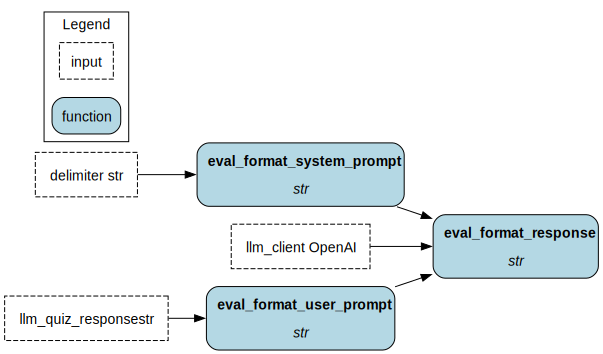

In [13]:
%%with_functions -m eval_format
import openai 

def eval_format_system_prompt(delimiter: str) -> str:
    return (
        "You are an assistant that evaluates whether or not an assistant is producing valid quizzes. "
        f"The assistant should be producing output in the format of Question N:{delimiter} <question N>?"
    )


def eval_format_user_prompt(llm_quiz_response: str) -> str:
    # one-shot
    return (
        "You are evaluating a generated quiz based on the context that the assistant uses to create the quiz.\n"
        "Read the response carefully and determine if it looks like a quiz or test. "
        "Do not evaluate if the information is correct only evaluate if the data is "
        "in the expected format.\n\n"
        "Output Y if the response is a quiz, output N if the response does not look like a quiz."
        "Here is the data:\n"
        "[BEGIN DATA]\n"
        "************\n"
        f"[Response]: {llm_quiz_response}\n"
        "************\n"
        "[END DATA]\n\n"
    )

def eval_format_response(
    eval_format_system_prompt: str, eval_format_user_prompt: str, llm_client: openai.OpenAI
) -> str:
    """Creates the RAG response from the LLM model for the given prompt.

    :param eval_format_system_prompt: the prompt to send to the LLM.
    :param eval_format_user_prompt: the prompt to send to the LLM.
    :param llm_client: the LLM client to use.
    :return: the response from the LLM.
    """
    response = llm_client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": eval_format_system_prompt},
            {"role": "user", "content": eval_format_user_prompt},
        ],
        temperature=0,
    )
    return response.choices[0].message.content

In [14]:
eval_format_driver = (
        driver.Builder()
        .with_modules(eval_format)
        .build()
)
eval_format_driver.execute(
    ["eval_format_response"], 
    inputs={
        "delimiter": "####",
        "llm_client": openai.OpenAI(),
        "llm_quiz_response": "Question 1:#### <question 1>\n\nQuestion 2:#### <question 2>\n\nQuestion 3:#### <question 3>"}
)

{'eval_format_response': 'Y'}

In [15]:
for response in [result2["llm_quiz_response"], result["llm_quiz_response"]]:
    print(response)
    print(eval_format_driver.execute(
        ["eval_format_response"], 
        inputs={
            "delimiter": "####",
            "llm_client": openai.OpenAI(),
            "llm_quiz_response": response}
    ))

Question 1:####
What famous painting did Leonardo DaVinci create?

Question 2:####
In addition to being an artist, what other fields did Leonardo DaVinci study?

Question 3:####
What invention did Leonardo DaVinci design?
{'eval_format_response': 'Y'}
Question 1:####
What famous painting did Leonardo DaVinci create?
a) The Starry Night
b) The Last Supper
c) The Scream
d) Guernica

Question 2:####
In addition to being an artist, what other fields did Leonardo DaVinci study?
a) Zoology, anatomy, geology, optics
b) Mathematics, astronomy, chemistry
c) Literature, philosophy, psychology
d) Music, dance, theater

Question 3:####
What invention did Leonardo DaVinci design?
a) The printing press
b) The telephone
c) The flying machine
d) The steam engine
{'eval_format_response': 'Y'}


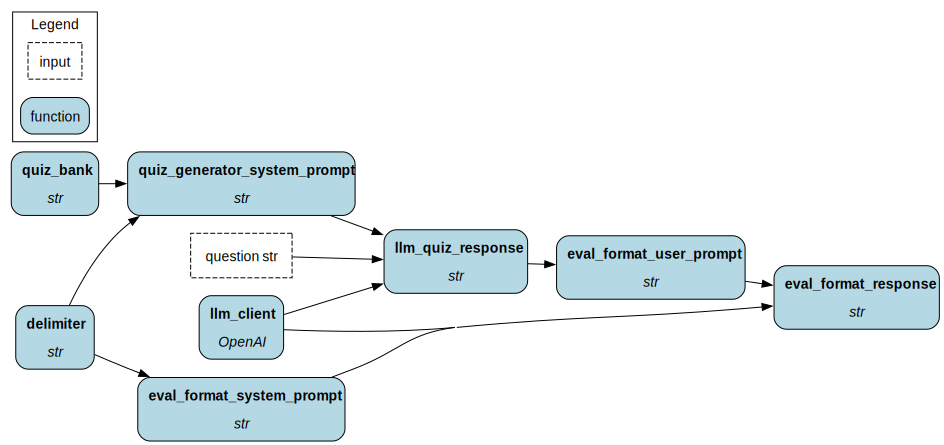

In [16]:
eval_format_driver = (
        driver.Builder()
        .with_modules(quiz, eval_format)
        .build()
)
eval_format_driver.display_all_functions()

In [17]:
eval_format_driver.execute(
    ["eval_format_response"], 
    inputs={"question": "Write me a quiz about Leonardo DaVinci"}
)

{'eval_format_response': 'Y'}

# question to ask yourself -- can a regex do this?

# let's take this to scale ... what happens?

You come up with a series of questions and then have responses / logic you want to grade against. 
```python
list_of_test_cases = [{"question": "Write me a quiz about Leonardo DaVinci",
 "response": "Question 1:#### <question 1>\n\nQuestion 2:#### <question 2>\n\nQuestion 3:#### <question 3>", 
"grade": "what this must pass or not"}, ...]
```

You need to version your prompt eval code as well as your LLM code, else you'll likely find it hard to reproduce results. "When did this test ever pass?"

# How could you come up with the test cases?
- Use LLMs!

# Can you use LLMs to suggest prompts? You can do that too...
- Use "generative" AI for what it's built for ;).



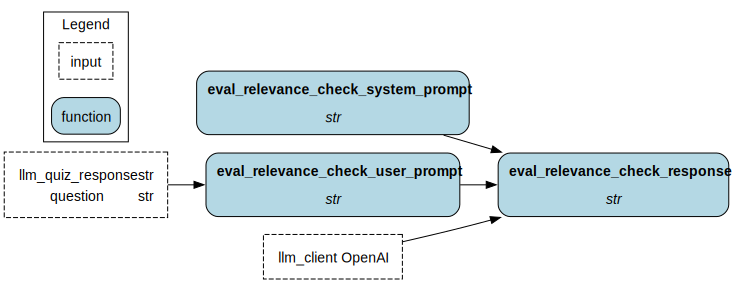

In [18]:
%%with_functions -m eval_relevance
import openai

def eval_relevance_check_system_prompt() -> str:
    return (
        "You are an assistant that evaluates how well the quiz assistant "
        "creates quizzes for a user by looking at the generated quize questions for relevance to the original ask.\n"
        "Your primary concern is making sure that the quiz is relevant to the original user ask.\n"
        "Helpful quizzes are what the user asked for."
    )


def eval_relevance_check_user_prompt(question: str, llm_quiz_response: str) -> str:
    return (
        "You are evaluating a generated quiz based on the context that the assistant used to create the quiz.\n"
        "Here is the data:\n"
        "[BEGIN DATA]\n"
        "************\n"
        f"[Original Ask]: {question}\n"
        "************\n"
        f"[Response]: {llm_quiz_response}\n"
        "************\n"
        "[END DATA]\n\n"
        """## Steps to make a decision
Compare the content of the response with the original ask using the following steps

1. Review the original ask. Every question in the quiz should be relevant to the original ask.
2. Compare the information in the quiz to the original ask.
3. Ignore differences in grammar or punctuation.

Remember, the quizzes should only contain questions that provide what as specified in the original ask.

Read the response carefully and determine if the quiz satisfies to the original ask. "
For example, ask yourself whether each quiz question satisfies the original ask. If any quiz question does "
not satisfy the original ask, output No.

## Additional rules
- Output an explanation of whether the quiz satisfies the original ask.
- Make the explanation brief only include a summary of your reasoning for the decision.
- Include a clear "Yes" or "No" as the first paragraph.

Separate the decision and the explanation. For example:

************
Decision: <Y>
************
Explanation: <Explanation>
************
"""
    ) 


def eval_relevance_check_response(
    eval_relevance_check_system_prompt: str,
    eval_relevance_check_user_prompt: str,
    llm_client: openai.OpenAI,
) -> str:
    """Creates the RAG response from the LLM model for the given prompt.

    :param eval_relevance_check_system_prompt: the prompt to send to the LLM.
    :param eval_relevance_check_user_prompt: the prompt to send to the LLM.
    :param llm_client: the LLM client to use.
    :return: the response from the LLM.
    """
    response = llm_client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": eval_relevance_check_system_prompt},
            {"role": "user", "content": eval_relevance_check_user_prompt},
        ],
        temperature=0,
    )
    return response.choices[0].message.content

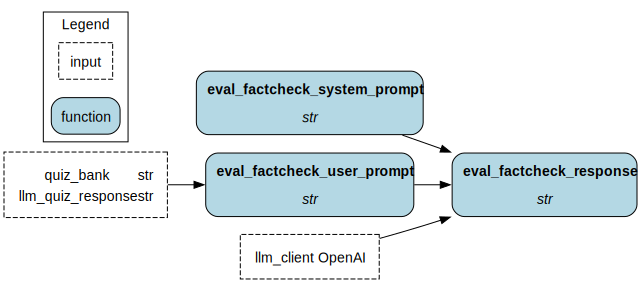

In [19]:
%%with_functions -m eval_factuality
import openai

def eval_factcheck_system_prompt() -> str:
    return (
        "You are an assistant that evaluates how well the quiz assistant "
        "creates quizzes for a user by looking at the set of facts available to the assistant.\n"
        "Your primary concern is making sure that ONLY facts available are used.\n"
        "Helpful quizzes only use facts contained in the question bank."
    )


def eval_factcheck_user_prompt(quiz_bank: str, llm_quiz_response: str) -> str:
    return f"""You are evaluating a generated quiz based on the question bank that the assistant uses to create the quiz. Your job is to evaluate the factuality of the quiz and ensure that answers to the quiz questions are found in the question bank.
Here is the data:
[BEGIN DATA]
************
[Question Bank]: {quiz_bank}
************
[Quiz]: {llm_quiz_response}
************
[END DATA]

## The question bank follows the following format:
Subject: <subject>
   Categories: <category1>, <category2>
   Facts:
    - <fact 1>
    - <fact 2>

## Steps to make a decision
Compare the quiz provided with the question bank using the following steps

1. Review the question bank carefully. These are the only facts the quiz can reference and ask questions about.
2. Compare the answer options the quiz asks for to the facts in the question bank. One of the answers should be found in the question bank. 
3. Ignore differences in grammar or punctuation.

Remember, a valid quiz answer should match a fact in the question bank. 

## Additional rules
- Output an explanation of whether each quiz question is asking a question about data in the quiz bank, and that one of the answer options is factually correct and found in the quiz bank.
- Make the explanation brief only include a summary of your reasoning for the decision.
- Include a clear "Yes" or "No" as the first paragraph.
- Reference the facts in full from the quiz bank if the answer is yes.

Separate the decision and the explanation. For example:

************
Decision: <Y>
************
Explanation: <Explanation>
************
"""

def eval_factcheck_response(
    eval_factcheck_system_prompt: str, eval_factcheck_user_prompt: str, llm_client: openai.OpenAI
) -> str:
    """Creates the RAG response from the LLM model for the given prompt.

    :param eval_factcheck_system_prompt: the prompt to send to the LLM.
    :param eval_factcheck_user_prompt: the prompt to send to the LLM.
    :param llm_client: the LLM client to use.
    :return: the response from the LLM.
    """
    response = llm_client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": eval_factcheck_system_prompt},
            {"role": "user", "content": eval_factcheck_user_prompt},
        ],
        temperature=0,
    )
    return response.choices[0].message.content

In [20]:
eval_factcheck_driver = (
        driver.Builder()
        .with_modules(eval_factuality)
        .build()
)
eval_factcheck_driver.execute(
    ["eval_factcheck_response"], 
    inputs={
        "quiz_bank": quiz.quiz_bank(),
        "llm_quiz_response": result["llm_quiz_response"],
        "llm_client": openai.OpenAI()
    }
)

{'eval_factcheck_response': '************\nDecision: Yes\n************\nExplanation: \n\nQuestion 1: The quiz asks for the famous painting created by Leonardo DaVinci. The correct answer is "b) The Last Supper," which is not found in the question bank. However, the fact "Painted the Mona Lisa" is available in the question bank, which is a famous painting created by Leonardo DaVinci. Therefore, the quiz question is asking about data in the question bank, but none of the answer options are factually correct and found in the question bank.\n\nQuestion 2: The quiz asks about the other fields that Leonardo DaVinci studied. The correct answer is "a) Zoology, anatomy, geology, optics," which is found in the question bank. The fact "Studied zoology, anatomy, geology, optics" is available in the question bank, which matches the correct answer option. Therefore, the quiz question is asking about data in the question bank, and one of the answer options is factually correct and found in the questi

In [21]:
result["llm_quiz_response"]

'Question 1:####\nWhat famous painting did Leonardo DaVinci create?\na) The Starry Night\nb) The Last Supper\nc) The Scream\nd) Guernica\n\nQuestion 2:####\nIn addition to being an artist, what other fields did Leonardo DaVinci study?\na) Zoology, anatomy, geology, optics\nb) Mathematics, astronomy, chemistry\nc) Literature, philosophy, psychology\nd) Music, dance, theater\n\nQuestion 3:####\nWhat invention did Leonardo DaVinci design?\na) The printing press\nb) The telephone\nc) The flying machine\nd) The steam engine'

In [22]:
eval_factcheck_driver = (
        driver.Builder()
        .with_modules(eval_factuality, eval_format, eval_relevance, quiz)
        .build()
)
eval_response_1 = eval_factcheck_driver.execute(
    ["llm_quiz_response", "eval_factcheck_response", "eval_relevance_check_response", "eval_format_response"], 
    inputs={
        "question": "I would like a science quiz please.",
    }
)
pprint.pprint(eval_response_1)

{'eval_factcheck_response': '************\n'
                            'Decision: Y\n'
                            '************\n'
                            'Explanation: \n'
                            '\n'
                            'Question 1: Yes, this question is asking about '
                            'the largest telescope in space and the material '
                            'of its mirror. The answer can be found in the '
                            'question bank. The largest telescope in space is '
                            'called the James Webb space telescope and its '
                            'mirror is made of gold-beryllium.\n'
                            '\n'
                            'Question 2: Yes, this question is asking about '
                            'whether water slows down the speed of light. The '
                            'answer can be found in the question bank. Water '
                            'does slow down the speed of lig

In [23]:
eval_response_2 = eval_factcheck_driver.execute(
    ["llm_quiz_response", "eval_factcheck_response", "eval_relevance_check_response", "eval_format_response"], 
    inputs={
        "question": "I would like a quiz about Leonardo DaVinci please.",
    }
)
pprint.pprint(eval_response_2)

{'eval_factcheck_response': '************\n'
                            'Decision: Yes\n'
                            '************\n'
                            'Explanation: \n'
                            '\n'
                            'Question 1: The quiz asks for the famous painting '
                            'created by Leonardo DaVinci. The fact "Painted '
                            'the Mona Lisa" from the question bank matches one '
                            'of the answer options, so the quiz question is '
                            'factually correct and found in the question '
                            'bank.\n'
                            '\n'
                            'Question 2: The quiz asks about the other fields '
                            'Leonardo DaVinci studied. The fact "Studied '
                            'zoology, anatomy, geology, optics" from the '
                            'question bank matches one of the answer options, '
           